# Synchronization Procedure Demo
mardis@uni-bremen.de

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from pyphysim.channels.fading import TdlChannel, TdlChannelProfile, TdlMimoChannel
from pyphysim.channels.fading_generators import JakesSampleGenerator, RayleighSampleGenerator
from pyphysim.modulators import OFDM, QPSK
from pyphysim.modulators.ofdm import OfdmOneTapEqualizer
from pyphysim.util.conversion import linear2dB

import phy_func as phyf

## Simulation Parameters

In [2]:
# seed for reproducability
np.random.seed(1)

# Physical layer cell identity
N_ID1 = np.random.randint(336) # cell ID group {0,..,335}
N_ID2 = np.random.randint(3)   # cell ID sector {0,1,2}
N_ID_Cell = 3 * N_ID1 + N_ID2  # cell identity ID

# OFDM Parameters 
mu = 0 # Numerology 38.211 Table 4.3.2-1 normal cyclic prefix only (for the second part of the simulation)
CP_SIZE = phyf.get_cp_length(mu, l = 0, extended_cp=False)
FFT_SIZE = 1024 # orig.: 4096
F_d = 2
JAKES_L = 20
F = 2.4e9 # Hz

NOISE = 5e-2

# k_ssb is a combination of higher layer parameters and is to be chosen for the sake of this simulation
# {0,1,2,...,23} for f < 6GHz expressed in multiples of 15kHz SCS
# {0,1,2,...,1} for f >= 6GHz expressed in multiples of 60kHz SCS
# See 38.211 7.4.3.1 
k_ssb = 3

## Generate resource grid for given SCS and frequency

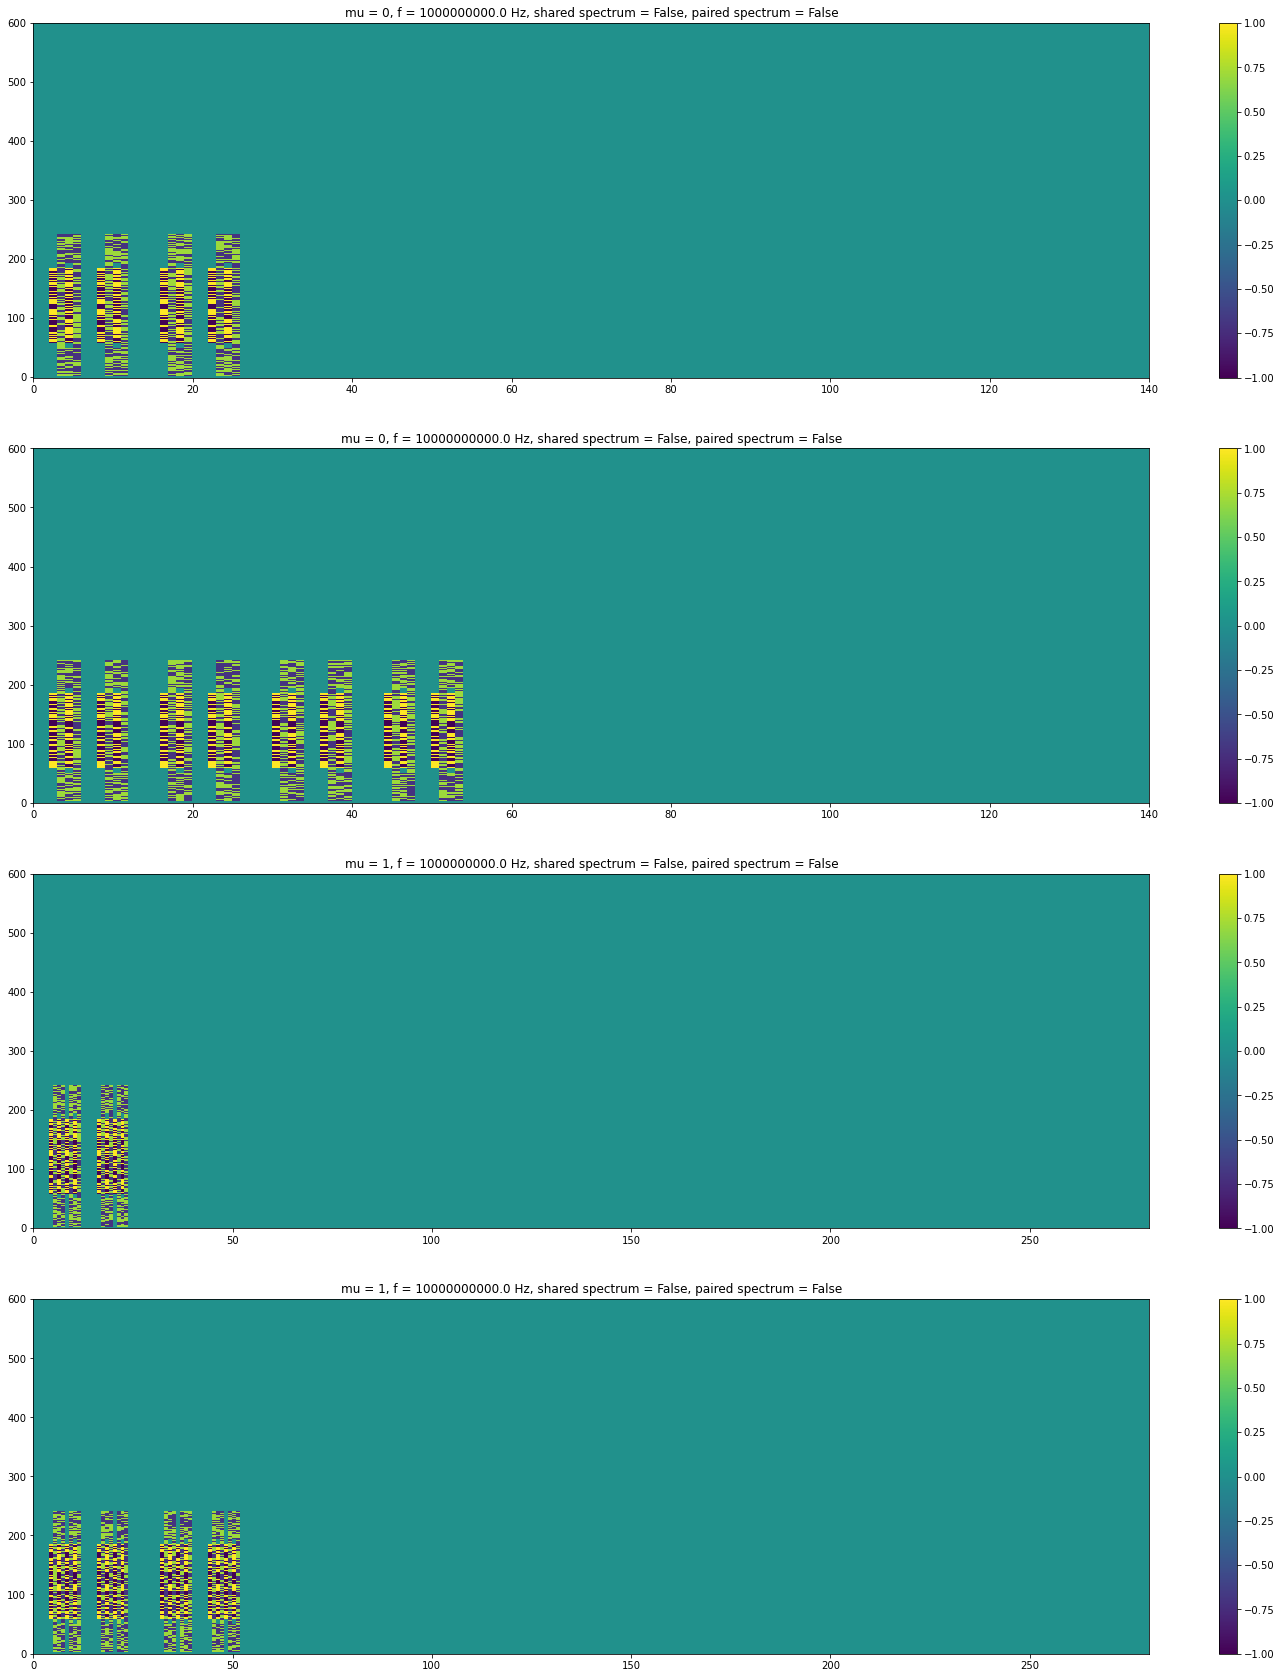

In [3]:
av_mu = [0,1] #[0,1,3,4]
av_f = [1e9, 10e9] # representatives for FR1 and FR2
av_sharedspectrum = [False] #[True, False]
av_pairedspectrum = [False]#[True, False]

av_configs = [[i,j,k,l] for i in av_mu for j in av_f for k in av_sharedspectrum for l in av_pairedspectrum]
av_configs = [x for x in av_configs if phyf.get_ssb_candidate_idx(*x).size] # Filter permutations which are not allowed (FR2)

fig, ax = plt.subplots(figsize=(25,30), nrows= len(av_configs))

for i, conf in enumerate(av_configs):
    rgrid = phyf.get_sync_resource_grid(50, N_ID1, N_ID2, k_ssb, *conf,)
    ax[i].set_title('mu = {}, f = {} Hz, shared spectrum = {}, paired spectrum = {}'.format(*conf))
    ax[i].pcolormesh(
        np.array(range(len(rgrid[0]))) + 0.5, 
        range(len(rgrid)), 
        np.real(rgrid), 
        shading='auto')
    plt.colorbar(ax[i].pcolor(np.real(rgrid)), ax=ax[i])


## Channel Model

In [4]:
channel = TdlChannel(
    fading_generator = JakesSampleGenerator(Fd=F_d, Ts=1e-8, L=JAKES_L ),
    channel_profile = TdlChannelProfile(*phyf.get_channel_profile('TDL_C', ds_desired = 49e-9)))


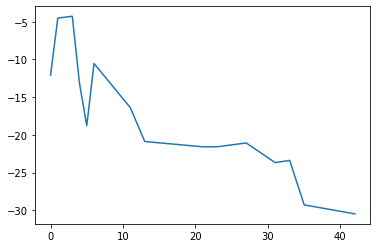

In [5]:
fig, ax = plt.subplots()
ax.plot(channel.channel_profile.tap_delays, channel.channel_profile.tap_powers_dB)

## Synchronization procedure

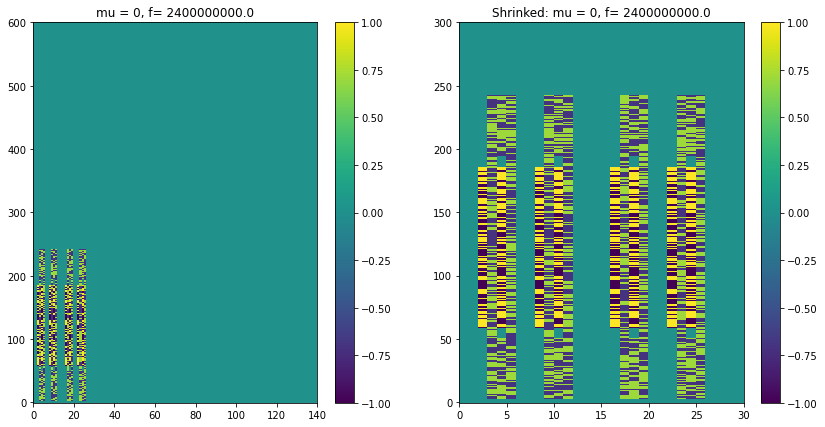

In [6]:
n_rb = 50 # Number of RBs 38.101 T-5.3.2-1

rgrid = phyf.get_sync_resource_grid(n_rb, N_ID1, N_ID2, k_ssb, mu, F)

fig, [ax1,ax2] = plt.subplots(figsize=(14, 7), ncols = 2)

ax1.set_title('mu = {}, f= {}'.format(mu,F))
ax1.pcolormesh(np.array(range(len(rgrid[0]))) + 0.5, range(len(rgrid)), np.real(rgrid), shading='auto')
plt.colorbar(ax1.pcolor(np.real(rgrid)), ax=ax1)

# Shrinking for easiercomputation
n_sc = 300
n_symb = 30
rgrid = rgrid[:n_sc, :n_symb]

ax2.set_title('Shrinked: mu = {}, f= {}'.format(mu,F))
ax2.pcolormesh(np.array(range(len(rgrid[0]))) + 0.5, range(len(rgrid)), np.real(rgrid), shading='auto')
plt.colorbar(ax2.pcolor(np.real(rgrid)), ax=ax2)

## Modulation

In [7]:
ofdm_modem = OFDM(FFT_SIZE, CP_SIZE, num_used_subcarriers= n_sc)

s = ofdm_modem.modulate(rgrid.flatten(order='F'))

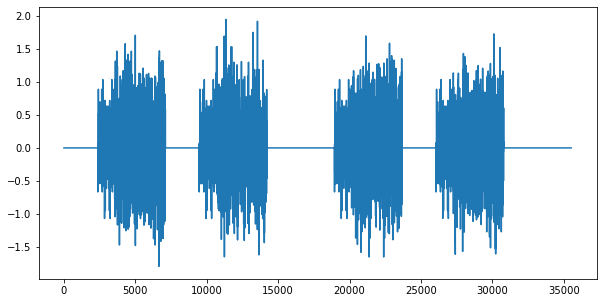

In [8]:
fig, ax2 = plt.subplots(figsize=(10,5))
ax2.plot(range(len(s)), np.real(s))

## Transmission

In [9]:
rec = channel.corrupt_data(s).flatten()
n = np.array([ complex(np.random.normal(0, NOISE, 1) + 1j * np.random.normal(0, NOISE, 1)) for i in range(len(rec))])
rec += n

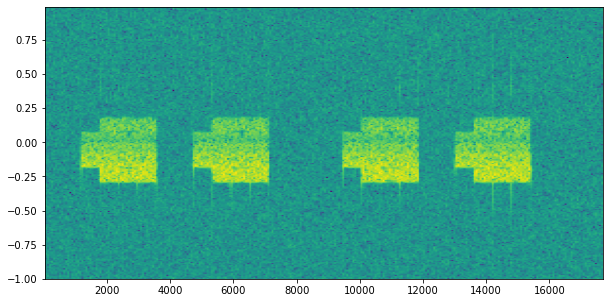

In [10]:
fig, ax3 = plt.subplots(figsize=(10,5))
_ = ax3.specgram(rec)

## Demodulation and equalization

In [11]:
rec_no = rec[:(FFT_SIZE + CP_SIZE) * n_symb]
demod_rec = ofdm_modem.demodulate(rec_no)

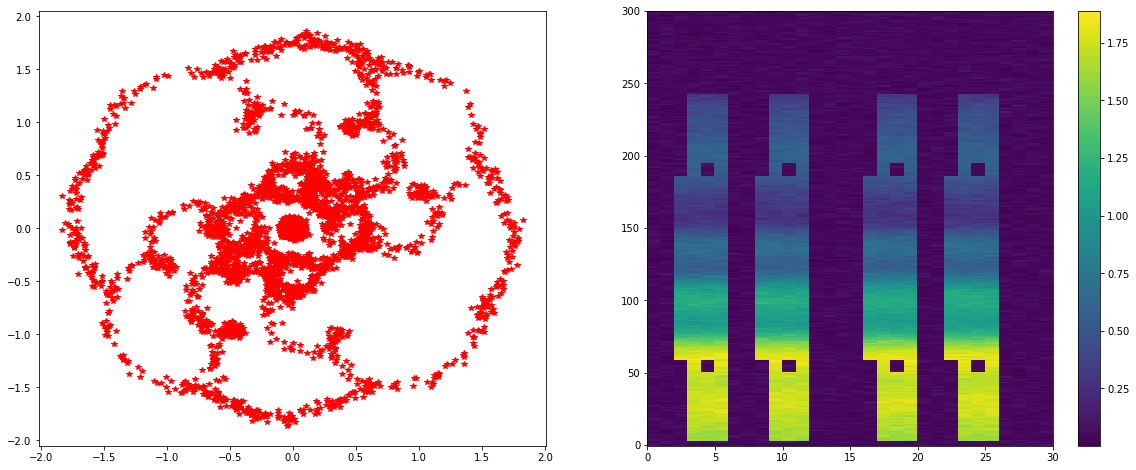

In [12]:
fig, [ax1, ax2] = plt.subplots(figsize=(20, 8), ncols=2)
rec_res_grid = np.transpose(np.resize(demod_rec, (n_symb, n_sc)))
ax2.pcolormesh(np.array(range(len(rec_res_grid[0]))) + 0.5, range(len(rec_res_grid)), np.real(rec_res_grid), shading='auto')
plt.colorbar(ax2.pcolor(abs(rec_res_grid)))

_= ax1.plot(np.real(rec_res_grid), np.imag(rec_res_grid), 'r*')

In [13]:
eq = OfdmOneTapEqualizer(ofdm_modem)
eq_rec = eq.equalize_data(demod_rec, channel.get_last_impulse_response())

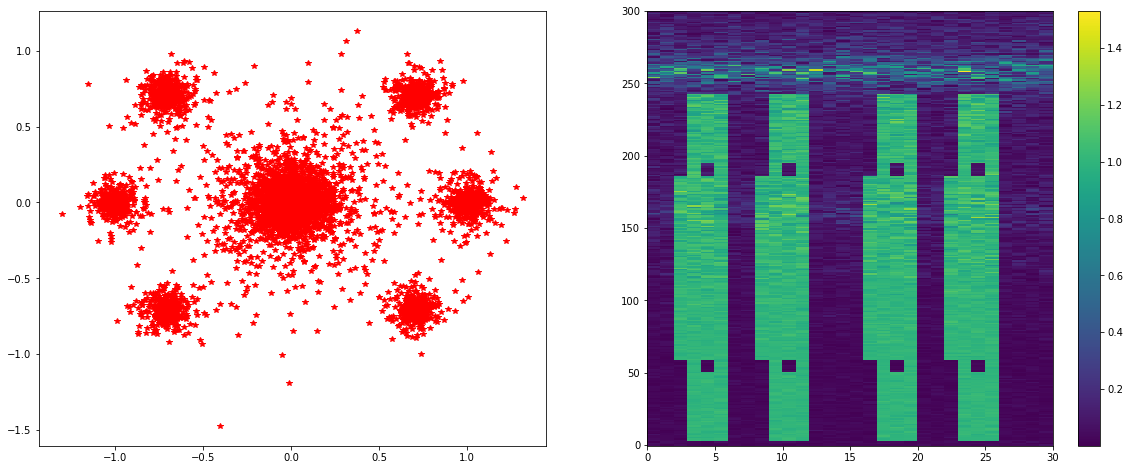

In [14]:
fig, [ax1, ax2] = plt.subplots(figsize=(20, 8), ncols=2)
eq_rec_res_grid = np.transpose(np.resize(eq_rec, (n_symb, n_sc)))
ax2.pcolormesh(np.array(range(len(eq_rec_res_grid[0]))) + 0.5, range(len(eq_rec_res_grid)), np.abs(eq_rec_res_grid), shading='auto')
plt.colorbar(ax2.pcolor(abs(eq_rec_res_grid)))

_ = ax1.plot(np.real(eq_rec_res_grid), np.imag(eq_rec_res_grid), 'r*')

## Decode PSS for N_ID2 and SSB_offsets

In [15]:
#known ssb_dim:
rec_ssb_dim = {
    'l' : 4,
    'k' : 240
}

rec_nid2, rec_k_offs, rec_l_offs =  phyf.decode_pss(eq_rec_res_grid, rec_ssb_dim)
print('N_ID2:{}\nk_offset:{}\nl_offset:{}:'.format(rec_nid2, rec_k_offs, rec_l_offs))

rec_ssb_dim['k_offset'], rec_ssb_dim['l_offset'] = rec_k_offs, rec_l_offs


N_ID2:0
k_offset:3
l_offset:16:


## Decode SSS for complete N_ID_Cell

In [16]:
rec_sss = phyf.unmap_sss(eq_rec_res_grid, rec_ssb_dim)
rec_nid1 = phyf.decode_sss(rec_sss, rec_nid2, rec_ssb_dim)
rec_n_id_cell = 3 * rec_nid1 + rec_nid2

rec_ssb_dim['nu'] = rec_n_id_cell % 4

print('N_ID1:{}\nN_ID_Cell:{}\nnu:{}\nrecN_ID1:{}\nrecN_ID_Cell:{}\nrecnu:{}:'
      .format(N_ID1, N_ID_Cell, rec_ssb_dim['nu'], rec_nid1, rec_n_id_cell, rec_ssb_dim['nu']))


N_ID1:37
N_ID_Cell:111
nu:3
recN_ID1:37
recN_ID_Cell:111
recnu:3:


## Decode PBCH for MIB